In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection


file_path = "output/electrode_npp_results.npz"

data = np.load(file_path)
nodes = data['nodes']
elements = data['elements']
c1_history = data['c1_history']
c2_history = data['c2_history']
phi_history = data['phi_history']
dt = data['dt'].item()  # Use .item() to get scalar value
num_steps = c1_history.shape[0]
phi_c = data['phi_c'].item()
tau_c = data['tau_c'].item()

In [8]:
phi = pd.DataFrame(phi_history)

In [9]:
phi

,0,1,2,3,4,5,6,7,8,9,...,951,952,953,954,955,956,957,958,959,960
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.004218,0.004488,0.005317,0.006769,0.008967,0.012130,0.016652,0.023318,0.033946,0.053639,...,-0.044802,-0.045363,-0.045869,-0.046314,-0.046695,-0.047011,-0.047257,-0.047435,-0.047542,-0.047577
2,0.004318,0.004589,0.005421,0.006878,0.009083,0.012254,0.016785,0.023462,0.034097,0.053787,...,-0.044892,-0.045455,-0.045963,-0.046410,-0.046792,-0.047109,-0.047357,-0.047535,-0.047642,-0.047678
3,0.004423,0.004694,0.005528,0.006988,0.009196,0.012371,0.016906,0.023583,0.034210,0.053875,...,-0.044942,-0.045507,-0.046016,-0.046464,-0.046849,-0.047166,-0.047415,-0.047593,-0.047701,-0.047737
4,0.004532,0.004804,0.005639,0.007101,0.009312,0.012489,0.017024,0.023699,0.034318,0.053957,...,-0.044994,-0.045562,-0.046072,-0.046522,-0.046908,-0.047226,-0.047476,-0.047655,-0.047763,-0.047799
5,0.004644,0.004916,0.005753,0.007216,0.009428,0.012606,0.017141,0.023812,0.034420,0.054034,...,-0.045048,-0.045618,-0.046131,-0.046582,-0.046969,-0.047289,-0.047539,-0.047719,-0.047827,-0.047863
6,-0.006058,-0.006316,-0.007109,-0.008501,-0.010613,-0.013662,-0.018040,-0.024528,-0.034925,-0.054283,...,0.040820,0.041403,0.041930,0.042395,0.042795,0.043126,0.043386,0.043573,0.043685,0.043723
7,-0.006141,-0.006401,-0.007199,-0.008599,-0.010724,-0.013790,-0.018191,-0.024704,-0.035121,-0.054474,...,0.040880,0.041464,0.041992,0.042459,0.042860,0.043192,0.043453,0.043640,0.043753,0.043790
8,-0.006246,-0.006507,-0.007309,-0.008716,-0.010851,-0.013929,-0.018342,-0.024863,-0.035276,-0.054594,...,0.040902,0.041487,0.042017,0.042484,0.042886,0.043219,0.043480,0.043668,0.043781,0.043819
9,-0.006364,-0.006627,-0.007433,-0.008846,-0.010988,-0.014074,-0.018493,-0.025015,-0.035418,-0.054701,...,0.040928,0.041515,0.042046,0.042514,0.042917,0.043251,0.043512,0.043701,0.043814,0.043852


In [10]:
np.sum(c1_history[0]), np.sum(c1_history[-1])

(np.float64(50.311945760410424), np.float64(50.860850731867444))

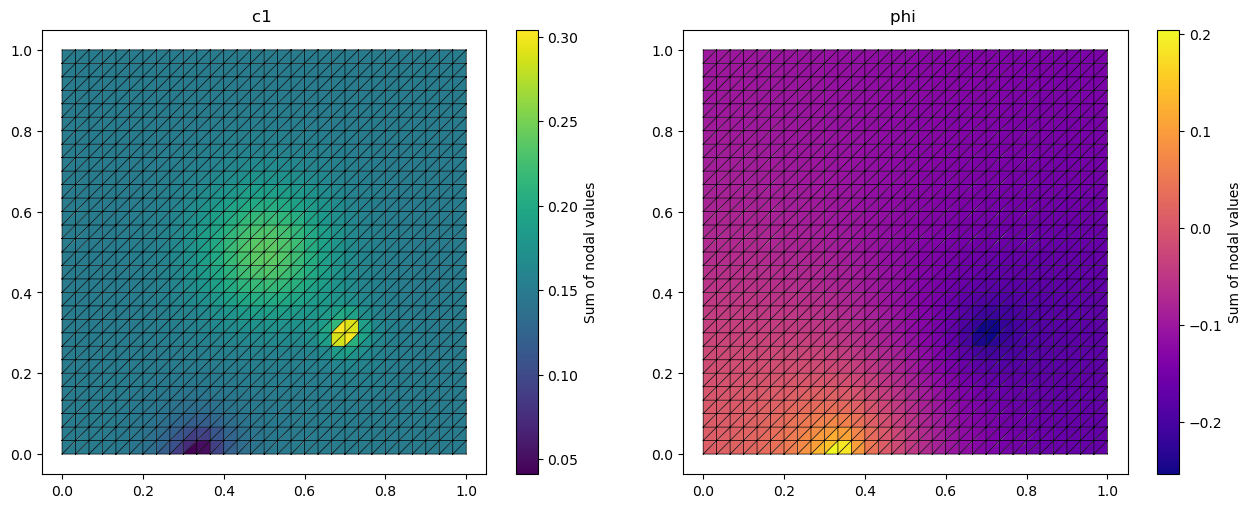

In [11]:
i = 1

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

                # --- Plot c1 on the first axis (ax1) ---
c1_triangle_values = c1_history[i][elements].sum(axis=1)
collection1 = PolyCollection(nodes[elements], cmap='viridis')
collection1.set_array(c1_triangle_values)
ax1.add_collection(collection1)
ax1.triplot(nodes[:, 0], nodes[:, 1], elements, 'k-', lw=0.5)
ax1.set_title(f"c1 ")
fig.colorbar(collection1, ax=ax1, label="Sum of nodal values")
ax1.autoscale_view()
ax1.set_aspect('equal')

                # --- Plot phi on the second axis (ax2) ---
phi_triangle_values = phi_history[i][elements].sum(axis=1)
collection2 = PolyCollection(nodes[elements], cmap='plasma')
collection2.set_array(phi_triangle_values)
ax2.add_collection(collection2)
ax2.triplot(nodes[:, 0], nodes[:, 1], elements, 'k-', lw=0.5)
ax2.set_title(f"phi ")
fig.colorbar(collection2, ax=ax2, label="Sum of nodal values")
ax2.autoscale_view()
ax2.set_aspect('equal')

                # --- Finalize and show the plot ---
plt.tight_layout()
plt.show()

In [12]:
from utils.fem_mesh import create_structured_mesh, TriangularMesh



nx, ny = 30, 30
Lx, Ly = 1.0e-7, 1.0e-7
nodes, elements = create_structured_mesh(Lx=Lx, Ly=Ly, nx=nx, ny=ny)
mesh = TriangularMesh(nodes, elements)

ValueError: too many values to unpack (expected 2)

In [ ]:
nodes.shape

(961, 2)